# Fitting Functions

*Purpose*: **TODO**.


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

# Fitting

Recall that there are four classes of verb in grama; *fitting* verbs take data as an input and produce a model as an output. There are various ways to fit a model; in this exercise we'll focus on fitting a *parameterized* model using  *nonlinear least squares*.



![Grama verb class diagram](./images/verb-classes.png)


## Trajectory Data


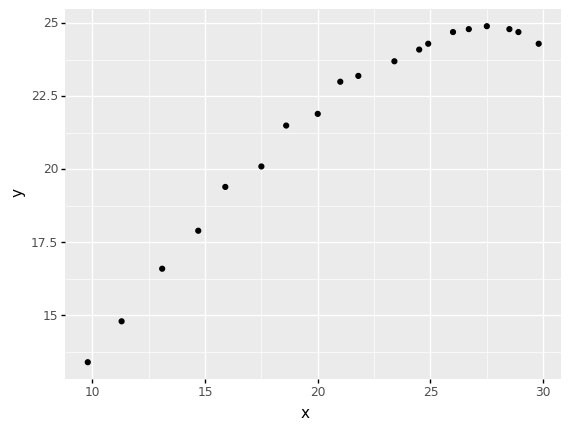

<ggplot: (8761140095082)>

In [2]:
from grama.data import df_trajectory_windowed
(
    df_trajectory_windowed
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_point()
)

# EMA of Proposed Model


## Trajectory model


In [3]:
from grama.models import make_trajectory_linear
md_trajectory = make_trajectory_linear()
md_trajectory

model: Trajectory Model

  inputs:
    var_det:
      tau: [0.05, inf]
      u0: [0.1, inf]
      v0: [0.1, inf]
      t: [0, 600]

    var_rand:

    copula:
      None

  functions:
      x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
      y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']

### Linear drag model

The drag $\vec{F}_d$ acting on the projectile in this model has a magnitude equal to

$$F_d \propto - m \tau s$$

where $m$ is the mass of the projectile, $s$ is its speed, and $\tau$ is the *time constant* associated with the drag law.

We can make sense of the model by inspecting the equations in the model. However, a complementary way to gain understanding is to do a little *exploratory model analysis*. You'll use EMA below to understand the model's behavior.


## Sinews and bounds

One "gotcha" with `ev_sinews()` is that it can only sweep inputs with *finite bounds*. For variables with one-sided bounds, such as `[0.1, inf]`, we cannot sweep values all the way to infinity! Instead, grama will set the inputs with one-sided bounds to their lower bound, and sweep the remaining variables. We need to set finite bounds in order to use `gr.ev_sinews()`.


### __qX__ Sweep values of `tau`

Update the model to enable a sweep over values of `tau`. How does changing `tau` affect the trajectory? Answer the questions under *observations* below.

*Hint*: Remember that `gr.cp_bounds()` allows you to adjust the bounds of a grama model. Note that you may need to adjust the bounds of time `t` as well as `tau` to make an informative plot.


Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


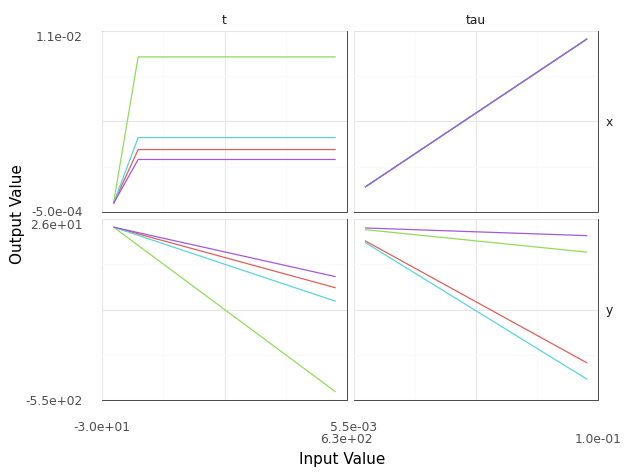

<ggplot: (8761175321429)>

In [4]:
(
    md_trajectory
    >> gr.cp_bounds(tau=[0.01, 0.1])
    >> gr.ev_sinews(df_det="swp", n_sweeps=4)
    >> gr.pt_auto()
)

*Observations*

- Once you get a sweep of `tau` displayed, what do each of the curves in the `tau` column represent?
  - Each curve in the `tau` column represents the effect `tau` has on the relevant output (`x` or `y`) *at a fixed point in time `t`*.
- What affect does `tau` have on the trajectory range `x` at a fixed point in time `t`?
  - Increasing `tau` tends to increase the range at a fixed point in time.
- What affect does `tau` have on the trajectory height `y` at a fixed point in time `t`?
  - Increasing `tau` tends to decrease the height at a fixed point in time.


### __qX__ Plot a few trajectories

Complete the code below to sweep over values of `tau` and `t`. Compare these results with what you found above. Answer the questions under *observations* below.


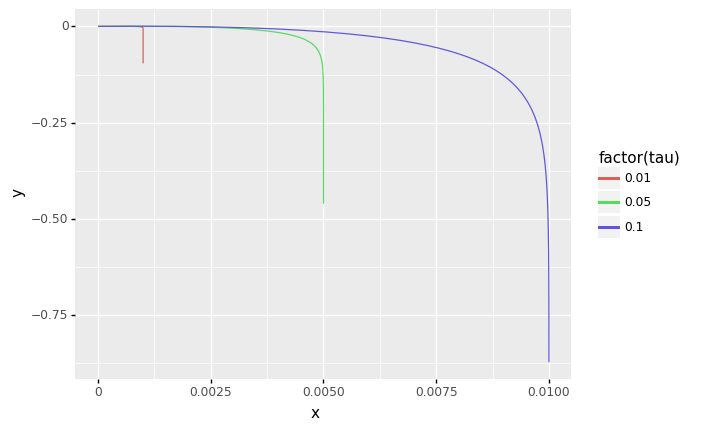

<ggplot: (8761154668650)>

In [5]:
# TASK: Sweep tau and t to create trajectories
(
    md_trajectory
    >> gr.ev_df(
        df=gr.df_grid(
            u0=0.1,
            v0=0.1,

            tau=[0.01, 0.05, 0.1],
            t=gr.linspace(0, 1, 100)
        )
    )
    >> gr.ggplot(gr.aes("x", "y", color="factor(tau)"))
    + gr.geom_line()
)

*Observations*

- What affect does `tau` have on the trajectory?
  - Increasing `tau` tends to extend the trajectory, allowing the projectile to reach longer distances.
- Imagine that `y == 0` represents the ground. Are the endpoints of these trajectories physically reasonable?
  - No; the endpoints are below the ground.


# Fitting with Least Squares

(Above, we guessed at parameter values. Now let's use fitting to get reasonable values.)


## The `ft_nls()` routine


### __qX__ Run `ft_nls()`


In [6]:
# TASK: 
md_fit = (
    df_trajectory_windowed
    >> gr.ft_nls(md=md_trajectory)
)

md_fit

... fit_nls setting out = ['x', 'y']
... eval_nls setting out = ['x', 'y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
    tau         u0          v0  tau_0  u0_0  v0_0  success  \
0  0.05  425.16129  447.996665   0.05   0.1   0.1     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  25.49725  


model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['t'] -> ['tau', 'u0', 'v0']
      Trajectory Model: ['tau', 't', 'u0', 'v0'] -> ['x', 'y']

*Observations*



### __qX__ Assess the fit


... provided columns intersect model output.
eval_df() is dropping {'x', 'y'}


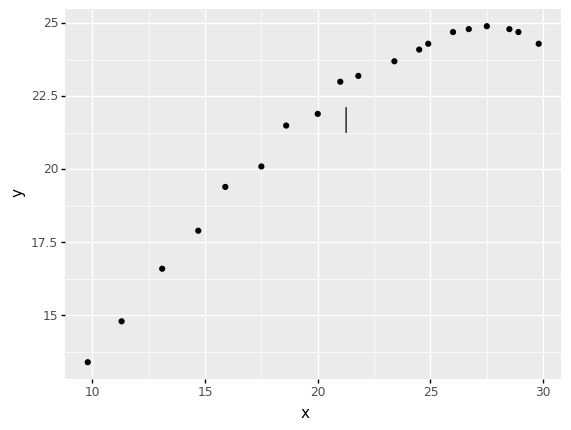

<ggplot: (8761175528804)>

In [7]:
# TASK: Compare the model predictions with
# the original data df_trajectory_windowed
(
    md_fit
    >> gr.ev_df(df_trajectory_windowed)
    
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_windowed)
)

*Observations*



## Rough estimation

Let's do some back-of-the envelope calculations to get a rough sense of reasonable parameter values.

### TODO

$$u = \frac{dx}{dt} \approx \frac{u(t_2) - u(t_1)}{t_2 - t_1}$$

The `gr.lead()` function allows us to access values in the following row; we can use this to implement differences like $u(t_2) - u(t_1)$.

$$F_d/m \propto - \tau s$$

or

$$a_d / s \propto \tau.$$

Note that this is *not* the total acceleration! This is just the acceleration due to drag, which we can't access from the data alone. However, we can use the *total* acceleration to set a reasonable first-guess for the value of `tau`.


In [8]:
# NOTE: No need to edit
(
    df_trajectory_windowed
    # Estimate velocity components
    >> gr.tf_mutate(
        u=(gr.lead(DF.x) - DF.x) / (gr.lead(DF.t) - DF.t),
        v=(gr.lead(DF.y) - DF.y) / (gr.lead(DF.t) - DF.t),
    )
    # Compute speed
    >> gr.tf_mutate(s=gr.sqrt(DF.u**2 + DF.v**2))
    # Estimate acceleration
    >> gr.tf_mutate(
        a=(gr.lead(DF.s) - DF.s) / (gr.lead(DF.t) - DF.t)
    )
    # Estimate drag time constant
    >> gr.tf_mutate(tau=gr.abs(DF.a / DF.s))
    
    >> gr.tf_select("u", "v", "tau")
    >> gr.tf_describe()
)

,u,v,tau
count,18.000000,18.000000,17.000000
mean,11.111111,6.055556,4.463891
std,4.114378,6.512181,4.756788
min,4.000000,-4.000000,0.194824
25%,8.250000,1.250000,1.401754
50%,11.000000,4.000000,2.465337
75%,14.750000,12.500000,5.897357
max,18.000000,18.000000,16.172505


### __qX__ Choose reasonable initial parameters

Override the default initial parameter guess of `ft_nls()` by adding a keyword argument. Using the rough estimates above, you should be able to achieve a fit of the data that is quite reasonable. Answer the questions under *observations* below.

*Hint*: Remember to consult the documentation for `ft_nls()` to see how to use its arguments!


... fit_nls setting out = ['x', 'y']
... eval_nls setting out = ['x', 'y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
       tau         u0         v0  tau_0  u0_0  v0_0  success  \
0  2.80225  18.792166  28.234799     16    18    18     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL      25  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'x', 'y'}


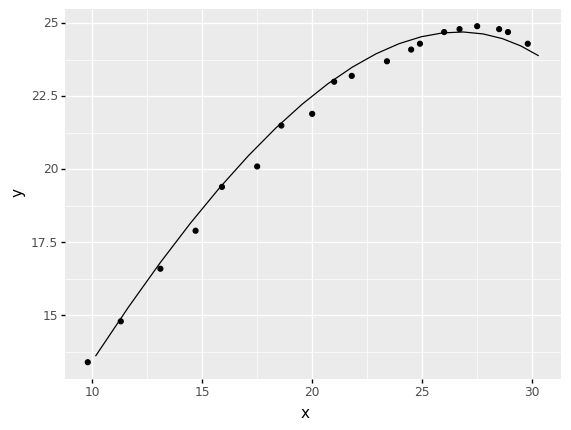

<ggplot: (8761154713585)>

In [9]:
# TASK: 
md_fit_init = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_trajectory,
        df_init=gr.df_make(
            u0=18,
            v0=18,
            tau=16,
        )
    )
)

(
    md_fit_init
    >> gr.ev_df(df_trajectory_windowed)
    
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_windowed)
)

*Observations*

- How well does the trend fit the data?
  - Quite well! Certainly much better than the previous attempt.
- How does your initial guess for `tau` compare with the fitted value? What might account for this?
  - My initial guess of `tau == 16` is quite a bit larger than the fitted value of `tau ~= 2.8`. As noted above, we estimated a time constant from the total acceleration, rather than the acceleration solely due to drag.
- How does your initial guess for `u0` compare with the fitted value? What might account for this?
  - My initial guess of `u0 == 18` is quite close to the fitted value of `u0 ~= 18.79`. The fitted value is larger, which makes intuitive sense (drag should slow the projectile), though it's closer than I might have expected.


# Model Assessment


## Quantifying uncertainty


In [10]:
# NOTE:  
md_fit_uq = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_trajectory,
        df_init=gr.df_make(
            u0=18,
            v0=18,
            tau=16,
        ),
        uq_method="linpool",
    )
)
md_fit_uq 

... fit_nls setting out = ['x', 'y']
... eval_nls setting out = ['x', 'y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
       tau         u0         v0  tau_0  u0_0  v0_0  success  \
0  2.80225  18.792166  28.234799     16    18    18     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL      25  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'x', 'y'}


/Users/zach/Git/py_grama/grama/fit_synonyms.py:133: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)

    var_rand:
      tau: (+0) norm, {'mean': '2.800e+00', 's.d.': '1.300e-01', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}
      u0: (+0) norm, {'mean': '1.879e+01', 's.d.': '1.700e-01', 'COV': 0.01, 'skew.': 0.0, 'kurt.': 3.0}
      v0: (+0) norm, {'mean': '2.823e+01', 's.d.': '2.000e-01', 'COV': 0.01, 'skew.': 0.0, 'kurt.': 3.0}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0  tau   u0 -0.678972
1  tau   v0 -0.704770
2   u0   v0  0.000000

  functions:
      Trajectory Model: ['tau', 't', 'u0', 'v0'] -> ['x', 'y']

### __qX__ Inspect plausible parameter values


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


/Users/zach/Git/py_grama/grama/plot_auto.py:234: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


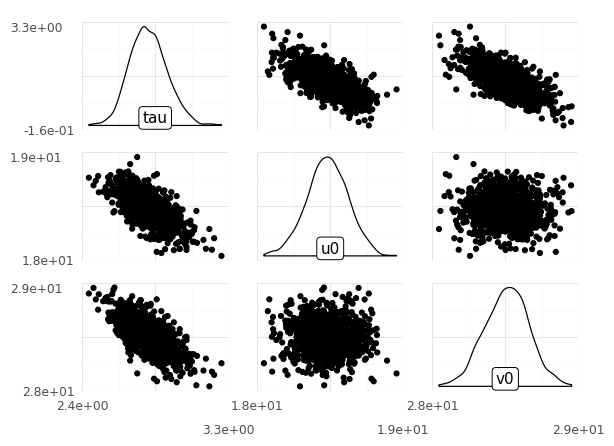

In [11]:
# TASK:
(
    md_fit_uq
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.pt_auto()
)

*Observations*



### __qX__ Inspect plausible trajectories


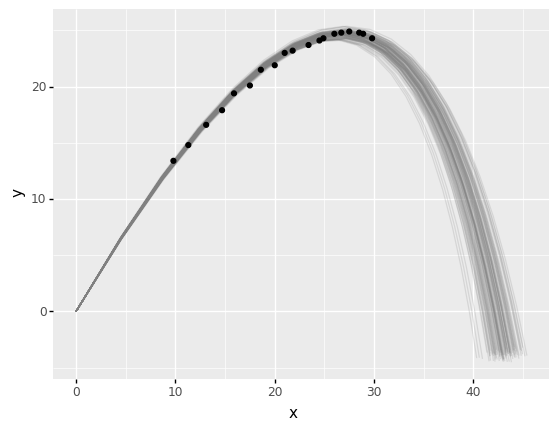

<ggplot: (8761154856394)>

In [12]:
# TASK:
(
    md_fit_uq
    >> gr.ev_sample(
        n=100, 
        df_det=gr.df_make(t=gr.linspace(0, 4.8, 20))
    )
    
    >> gr.ggplot(gr.aes("x", "y"))
    # NOTE: The `group` aesthetic allows us to draw
    # individual lines for each value of u0; otherwise
    # the lines would all be connected
    + gr.geom_line(gr.aes(group="u0"), alpha=1/5, color="grey")
    # Add the data
    + gr.geom_point(data=df_trajectory_windowed)
)

*Observations*



# Model Validation

## Validation data


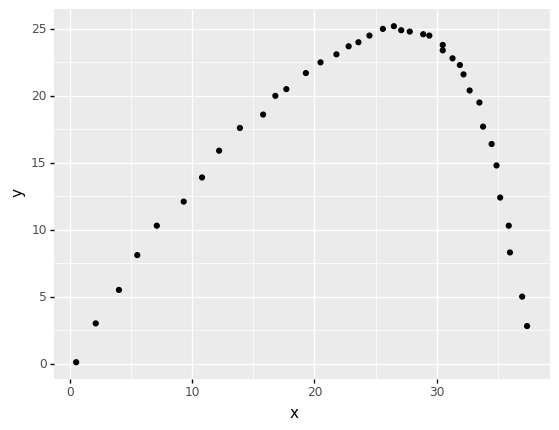

<ggplot: (8761140776665)>

In [13]:
from grama.data import df_trajectory_full
(
    df_trajectory_full
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_point()
)

### __qX__ Compare the fit to validation data




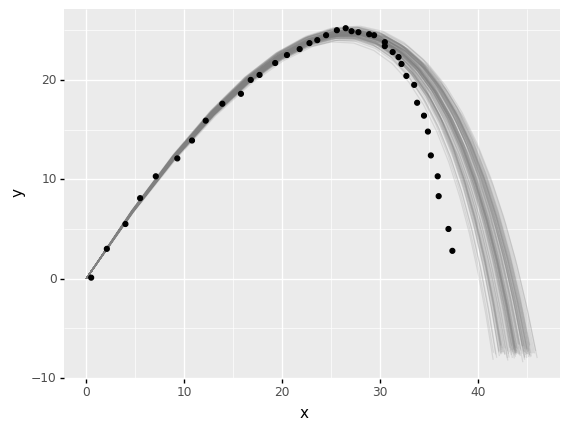

<ggplot: (8761140563357)>

In [14]:
# TASK: Compare the fitted model to the validation data;
# make sure to quantify the parameter uncertainty
(
    md_fit_uq
# solution-begin 
    >> gr.ev_sample(
        n=100, 
        df_det=gr.df_make(t=gr.linspace(0, 5, 20))
    )
    
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line(gr.aes(group="u0"), alpha=1/5, color="grey")
    + gr.geom_point(data=df_trajectory_full)
# solution-end 
)

*Observations*

